# 知識點
OpenCV 常用在電腦視覺任務中，作為在圖上加入適當標記的工具 (有助於了解結果的正確性)
- 偵測：標記預選框/偵測框等
- 遮罩：標記遮照等
- 追蹤：標記時間內移動軌跡/輪廓等
- 預處理：檢查經過 transformation 後的標記是否正確等

## 矩形
通常用於定位目標位置時
```python
cv2.rectangle(
    img, # 圖片
    (60, 40), # 左上角座標
    (420, 510), # 右上角座標
    (0, 0, 255), # BGR 顏色
    3) # 線的粗細 (若為負值則代表填滿)
```

> OpenCV 畫圖是直接畫在圖片上面，並不是回傳一個畫好圖的圖片

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
img = cv2.imread('lena.png')

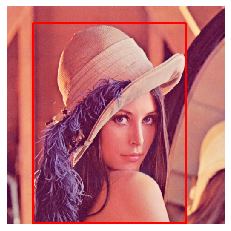

In [2]:
img_rect = img.copy()
cv2.rectangle(img_rect, (60, 40), (420, 510), (0, 0, 255), 3)
                                              # ↑ 注意轉換為 RGB 的情況
img_rect = cv2.cvtColor(img_rect, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(img_rect);

## 線
通常用於標記路徑/輪廓時
```python
cv2.line(
    img, # 圖片
    (60, 40), # 左上角座標
    (420, 510), # 右上角座標
    (0, 0, 255), # BGR 顏色
    3) # 線的粗細
```

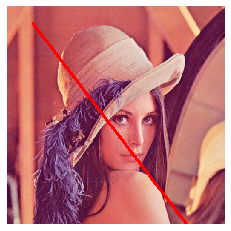

In [3]:
img_line = img.copy()
cv2.line(img_line, (60, 40), (420, 510), (0, 0, 255), 5)

img_line = cv2.cvtColor(img_line, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(img_line);

## 文字

```python
cv2.putText(
    img, # 圖片
    '(60, 40)', # 要加的文自
    (60, 40), # 文字左下角座標
    0, # 字型
    3, # 字體大小
    (0, 0, 255), # 字體顏色
    3) # 字體粗細
```

字型請參考 [Fonts in OpenCV](https://codeyarns.github.io/tech/2015-03-11-fonts-in-opencv.html)

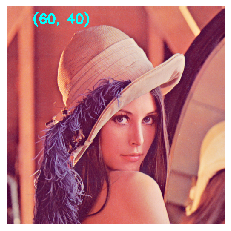

In [4]:
img_text = img.copy()
cv2.putText(img_text, '(60, 40)', (60, 40), 0, 1, (255, 255, 0), 3)

img_text = cv2.cvtColor(img_text, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(img_text);

#  作業

Hint: 人物原始邊框座標 (60, 40), (420, 510)

假設我們希望先對圖片做以下幾點預處理，請印出最後結果

- 對明亮度做直方圖均衡處理
- 水平鏡像 + 縮放處理 (0.5 倍)
- 畫出人物矩形邊框

##  解法一

根據題目，參考之前的投影片，最簡單的方式是

1. 顏色的操作 (對明亮度做直方圖均衡)
2. 把矩形邊框畫在圖片上之後在做位置上的變換

得到的圖的結果正確，但你不知道新的矩型邊框座標點

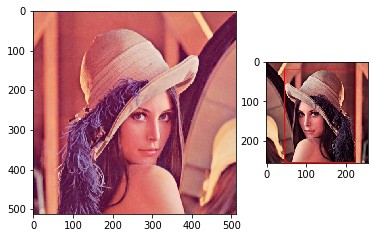

In [5]:
img_hw = img.copy()
point1 = (60, 40)
point2 = (420, 510)

"""對明亮度做直方圖平均化"""
# 轉為 HSV
img_hw = cv2.cvtColor(img_hw, cv2.COLOR_BGR2HSV)
# 對明亮度做直方圖平均化
img_hw[..., 2] = cv2.equalizeHist(img_hw[..., 2])
# 將圖片轉為 RGB
img_hw = cv2.cvtColor(img_hw, cv2.COLOR_HSV2RGB)

"""畫出矩形"""

cv2.rectangle(img_hw, point1, point2, (255, 0, 0), 3)
                                      # ↑ 已轉換為 RGB
    
"""水平鏡像 + 縮放處理 (0.5 倍)"""
# 水平鏡像 (圖片)
img_hw = img_hw[:, ::-1, :]

# 縮放
img_hw = cv2.resize(img_hw, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_LINEAR)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [img.shape[0], img_hw.shape[0]]})
axs[0].imshow(img_rgb)
axs[1].imshow(img_hw);

##  解法二

如果希望得知矩型邊框的位置

1. 顏色的操作 (對明亮度做直方圖均衡)
2. 鏡像可以透過四則運算得知
3. 透過建構 transformation matrix 做縮放
4. 把矩型邊框的點與 transformation matrix 相乘就會得到縮放後的位置
5. 畫圖

得到的圖的結果正確，同時也知道新的矩型邊框座標點

M_scale.shape=(2, 3), bbox.shape=(2, 2)
origin point1=[420, 40], origin point2=[60, 510]
resize point1=(210, 20), resize point2=(30, 255)


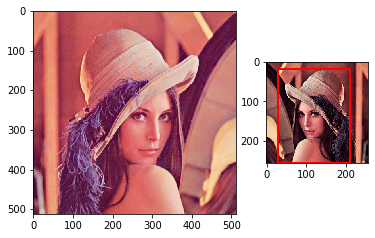

In [6]:
img_hw = img.copy()
point1 = [60, 40]
point2 = [420, 510]

"""
對明亮度做直方圖均衡
"""
# 原始 BGR 圖片轉 HSV 圖片
img_hw = cv2.cvtColor(img_hw, cv2.COLOR_BGR2HSV)
# 對明亮度做直方圖均衡 -> 對 HSV 的 V 做直方圖均衡
img_hw[..., 2] = cv2.equalizeHist(img_hw[..., 2])
# 將圖片轉回 BGR
img_hw = cv2.cvtColor(img_hw, cv2.COLOR_HSV2BGR)

"""
水平鏡像
"""
h, w = img_hw.shape[:2]

# 圖片鏡像
img_hw = img_hw[:, ::-1, :]

# 透過四則運算計算鏡像後位置
# 確保點的位置一樣是左上跟右下，所以交換鏡像後的 x 座標 (y 座標做水平鏡像後位置不變)
point1[0], point2[0] = point2[0], point1[0]

"""
縮放處理 (0.5 倍)
"""
fx = 0.5
fy = 0.5
resize_col = int(w*fx)
resize_row = int(h*fy)

# 建構 scale matrix
M_scale = np.array([[fx, 0, 0],
                    [0, fy, 0]], dtype=np.float32)
img_hw = cv2.warpAffine(img_hw, M_scale, (resize_col, resize_row))

# 把左上跟右下轉為矩陣型式
bbox = np.array((point1, point2), dtype=np.float32)
print('M_scale.shape={}, bbox.shape={}'.format(M_scale.shape, bbox.shape))

# 做矩陣乘法可以使用 `np.dot`, 為了做矩陣乘法, M_scale 需要做轉置之後才能相乘
homo_coor_result = np.dot(M_scale.T, bbox)
homo_coor_result = homo_coor_result.astype('uint8')
#print(homo_coor_result)
scale_point1 = tuple(homo_coor_result[0])
scale_point2 = tuple(homo_coor_result[1])
print('origin point1={}, origin point2={}'.format(point1, point2))
print('resize point1={}, resize point2={}'.format(scale_point1, scale_point2))

# 畫圖
cv2.rectangle(img_hw, scale_point1, scale_point2, (0, 0, 255), 3)

fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [img.shape[0], img_hw.shape[0]]})
img_hw_rgb = cv2.cvtColor(img_hw, cv2.COLOR_BGR2RGB)
axs[0].imshow(img_rgb)
axs[1].imshow(img_hw_rgb);

##  解法三 (optional)

把矩型邊框用遮罩的方式呈現，使用同樣處理圖片的方式處理遮罩
最後再找遮罩的左上跟右下的點的位置

這邊會用到許多沒提過的東西，所以當作 optional

# 延伸閱讀
[Drawing Functions in OpenCV](https://docs.opencv.org/3.1.0/dc/da5/tutorial_py_drawing_functions.html)